Мы владеем сетью магазинов, в которых продаются различные товары.  

Наши сотрудники собрали датасет из 8523 продаж товаров в различных магазинах нашей сети. Наша задача построить модель, предсказывающую продажи каждого продукта в конкретном магазине.  

Используя эту модель, попробовать выявить факторы, больше всего влияющие на увеличение продаж.  

Описание датасета:

Variable	Description  
- Item_Identifier	Id продукта  
- Item_Weight	Вес продукта  
- Item_Fat_Content	Содержание жира в продукте  
- Item_Visibility	%полок, отведенный под наш продукт в конкретном магазине  
- Item_Type	Категория продукта  
- Item_MRP	Максимальная цена продажи продукта  
- Outlet_Identifier	Идентификатор магазина  
- Outlet_Establishment_Year	Год открытия магазина  
- Outlet_Size	Площадь магазина  
- Outlet_Location_Type	Тип города, в котором расположен магазин  
- Outlet_Type	Признак является ли магазин продуктовым или супермаркетом  
- Item_Outlet_Sales	Продажи продукта в конкретном магазине. Именно ее и надо предсказывать  

В результате работы должен получиться:  
- Jupyter-ноутбук с моделью  
- Признаки, влияющие больше всего на уровень продаж  
- Датасет, если после ваших манипуляций он отличается от исходного;  
- Документ с обоснованием решения и краткими результатами: какие техники и почему использовали, что получили, что можно улучшить (можно в рамках jupyter notebook’а)

Баллы	Что надо сделать  
10	Провести EDA  
10	Обработать категориальные признаки   
10	Устранить пропущенные значения  
10	Изучить корреляцию признаков с данными о продажах  
10	Выбрать и обосновать метрику, на основе которой будем измерять качество полученной модели  
20	Построить и подобрать оптимальные параметры для любой линейной модели  
20	Построить и подобрать оптимальные параметры для любой нелинейной модели  
20	Провести стекинг нескольких моделей  
10	Оценить качество модели на отложенной выборке  
10	Выбрать топ 3 признака больше всего влияющие на объемы продаж  

Все шаги решения должны сопровождаться подробным описанием полученных результатов и обоснованием выбора того или иного шага!  
За отсутствие описания так же будут снижаться баллы.  

Максимальное доступное количество баллов - 130  
Для получения зачета надо набрать минимум 80 баллов  
Для получения зачета с отличием надо набрать минимум 120 баллов  

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

C:\Users\econo\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
data = pd.read_csv('data.csv')
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Провести EDA

In [ ]:
# посмотрим глазами основные характеристики датасета

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,7060.0,12.857645,4.643456,4.555,8.773750,12.600000,16.850000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


In [27]:
columns_cat = data.select_dtypes(object).columns
columns_digit = data.select_dtypes(exclude=object).columns

print(f'Количество категориальных переменных: {len(columns_cat)}')
print(f'Количество количественных переменных: {len(columns_digit)}')

Количество категориальных переменных: 7
Количество количественных переменных: 5


In [58]:
# есть странный min=0 у признака Item_Visibility, а может и не странный

# есть нулевые значения Item_Weight, Outlet_Size
# много категорильных переменных, необходимо с ними поработать

In [61]:
columns_digit

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

# Устранить пропущенные значения

In [67]:
# Item_Weight

In [57]:
data[data.Item_Weight.isna() == 1].count()
data[data.Item_Weight.isna() == 1]

# 1463 нулевых значения; 6113 ненулевых значения; 
# гипотезы:
# - это островки, которые реально не имеют признака. Можно уставить нулевыи или заполнить отрицательным значением
# - значение на самом деле есть, но по какой-то причине отсутствуют. Необходимо предсказать значения признака

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362
...,...,...,...,...,...,...,...,...,...,...,...,...
8485,DRK37,NaN,Low Fat,0.043792,Soft Drinks,189.0530,OUT027,1985,Medium,Tier 3,Supermarket Type3,6261.8490
8487,DRG13,NaN,Low Fat,0.037006,Soft Drinks,164.7526,OUT027,1985,Medium,Tier 3,Supermarket Type3,4111.3150
8488,NCN14,NaN,Low Fat,0.091473,Others,184.6608,OUT027,1985,Medium,Tier 3,Supermarket Type3,2756.4120
8490,FDU44,NaN,Regular,0.102296,Fruits and Vegetables,162.3552,OUT019,1985,Small,Tier 1,Grocery Store,487.3656


In [69]:
# Outlet_Size

In [70]:
data[data.Outlet_Size.isna() == 1].count()
data[data.Outlet_Size.isna() == 1]

# 2410 нулевых значения; 7060 ненулевых значения; 
# гипотезы:
# - это островки, которые реально не имеют признака. Можно уставить нулевыи или заполнить отрицательным значением
# - значение на самом деле есть, но по какой-то причине отсутствуют. Необходимо предсказать значения признака

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350
25,NCD06,13.000,Low Fat,0.099887,Household,45.9060,OUT017,2007,NaN,Tier 2,Supermarket Type1,838.9080
28,FDE51,5.925,Regular,0.161467,Dairy,45.5086,OUT010,1998,NaN,Tier 3,Grocery Store,178.4344
...,...,...,...,...,...,...,...,...,...,...,...,...
8502,NCH43,8.420,Low Fat,0.070712,Household,216.4192,OUT045,2002,NaN,Tier 2,Supermarket Type1,3020.0688
8508,FDW31,11.350,Regular,0.043246,Fruits and Vegetables,199.4742,OUT045,2002,NaN,Tier 2,Supermarket Type1,2587.9646
8509,FDG45,8.100,Low Fat,0.214306,Fruits and Vegetables,213.9902,OUT010,1998,NaN,Tier 3,Grocery Store,424.7804
8514,FDA01,15.000,Regular,0.054489,Canned,57.5904,OUT045,2002,NaN,Tier 2,Supermarket Type1,468.7232


# Обработать количественные признаки

In [62]:
columns_digit

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

In [63]:
# Item_Weight
data.Item_Weight.value_counts()

12.150    86
17.600    82
13.650    77
11.800    76
15.100    68
          ..
7.560      2
9.420      1
5.400      1
6.520      1
7.685      1
Name: Item_Weight, Length: 415, dtype: int64

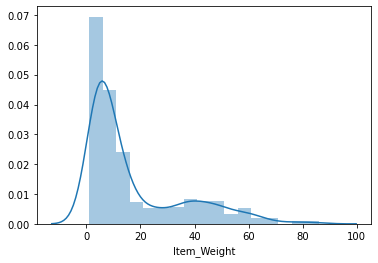

In [68]:
sns.distplot(data.Item_Weight.value_counts())

In [59]:
# Item_Visibility
data.Item_Visibility.value_counts()

0.000000    526
0.076975      3
0.041283      2
0.085622      2
0.187841      2
           ... 
0.092576      1
0.067544      1
0.115168      1
0.146896      1
0.050902      1
Name: Item_Visibility, Length: 7880, dtype: int64

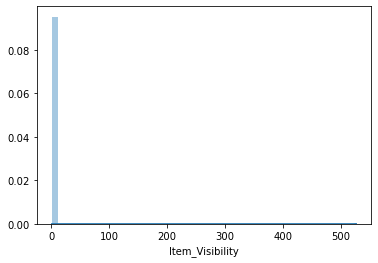

In [72]:
sns.distplot(data.Item_Visibility.value_counts())

In [64]:
#Item_MRP
data.Item_MRP.value_counts()

172.0422    7
188.1872    6
170.5422    6
109.5228    6
196.5084    6
           ..
212.8218    1
190.3872    1
162.6868    1
189.1214    1
51.3008     1
Name: Item_MRP, Length: 5938, dtype: int64

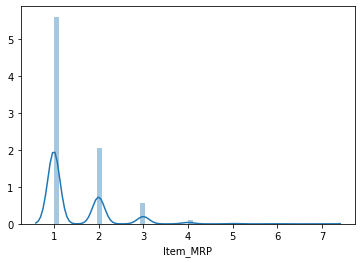

In [73]:
sns.distplot(data.Item_MRP.value_counts())

In [65]:
# Outlet_Establishment_Year
data.Outlet_Establishment_Year.value_counts()

1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

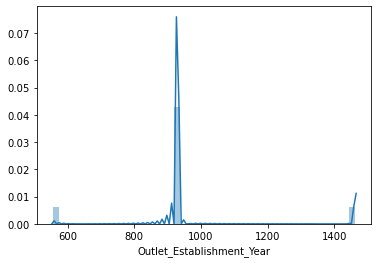

In [74]:
sns.distplot(data.Outlet_Establishment_Year.value_counts())

In [66]:
# Item_Outlet_Sales
data.Item_Outlet_Sales.value_counts()

958.7520     17
1342.2528    16
1845.5976    15
703.0848     15
1278.3360    14
             ..
3167.8764     1
2226.4352     1
1684.4740     1
1574.6170     1
6692.6216     1
Name: Item_Outlet_Sales, Length: 3493, dtype: int64

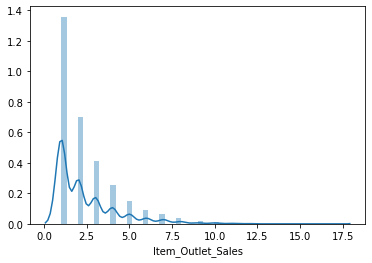

In [75]:
sns.distplot(data.Item_Outlet_Sales.value_counts())

# Обработать категориальные признаки

In [60]:
columns_cat

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

# Изучить корреляцию признаков с данными о продажах

# Выбрать и обосновать метрику, на основе которой будем измерять качество полученной модели

# Построить и подобрать оптимальные параметры для любой линейной модели

# Построить и подобрать оптимальные параметры для любой нелинейной модели

# Провести стекинг нескольких моделей

# Оценить качество модели на отложенной выборке

# Выбрать топ 3 признака больше всего влияющие на объемы продаж